<a href="https://colab.research.google.com/github/catebarry/xai-assignments/blob/main/assignments/assignment-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment 1: Interpretable ML
#### We are working with a dataset from a telecommunications company to understand the factors that contribute to customer churn and develop interpretable models to predict which customers are at risk of churning.

### Catie Barry


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catebarry/xai-assignments/blob/main/assignment-01.ipynb)

In [7]:
# installations

!pip install pandas==1.3.0

  Using cached pandas-1.3.0.tar.gz (4.7 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 2
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 2
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [8]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "xai-assignments" # Change to your repo name
git_path = 'https://github.com/catebarry/xai-assignments.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'assignments'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
Cloning into 'xai-assignments'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 51 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 182.38 KiB | 1.96 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/xai-assignments/assignments/xai-assignments/assignments
assignment-1.ipynb  data/


# Exploratory Data Analysis to Check Assumptions

We begin by exploring the Telco Customer Churn dataset to understand its structure, distributions, and potential issues that might violate regression assumptions.

In this section, we will:
- Load and clean the dataset
- Explore the target variable (`Churn`) and class balance
- Visualize numeric and categorical features
- Identify potential violations of model assumptions:
  - Linearity
  - Independence of observations
  - Homoscedasticity
  - Normality of residuals
  - No multicollinearity
  - No influential outliers

⚠️ Note: Some assumptions (linearity, homoscedasticity, normality) require residuals and will be fully tested later, once we fit regression models.

### 1. Load and Inspect the Dataset

We will use the [Telco Customer Churn dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn).  

The dataset contains customer demographics, account information, service usage, billing details, and whether the customer churned (`Churn`).


In [25]:
# load dataset
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# inspect
print("Shape:", df.shape)
df.info()
df.head()

Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2. Target Variable and Data Cleaning

- `Churn`: convert Yes → 1, No → 0  
- `TotalCharges`: coerce to numeric (fix blank values), replace missing with median

In [26]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

### 3. Churn Class Balance

We check whether churned vs. non-churned customers are balanced.

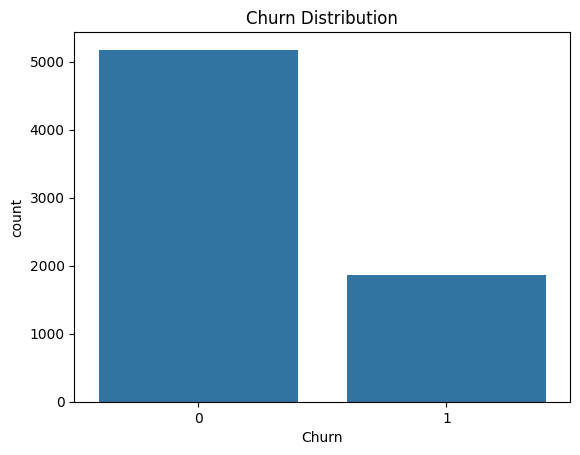

In [29]:
# class balance
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

### 4. Distribution of Numeric Features

We examine `tenure`, `MonthlyCharges`, and `TotalCharges` to check for skewness and potential outliers.

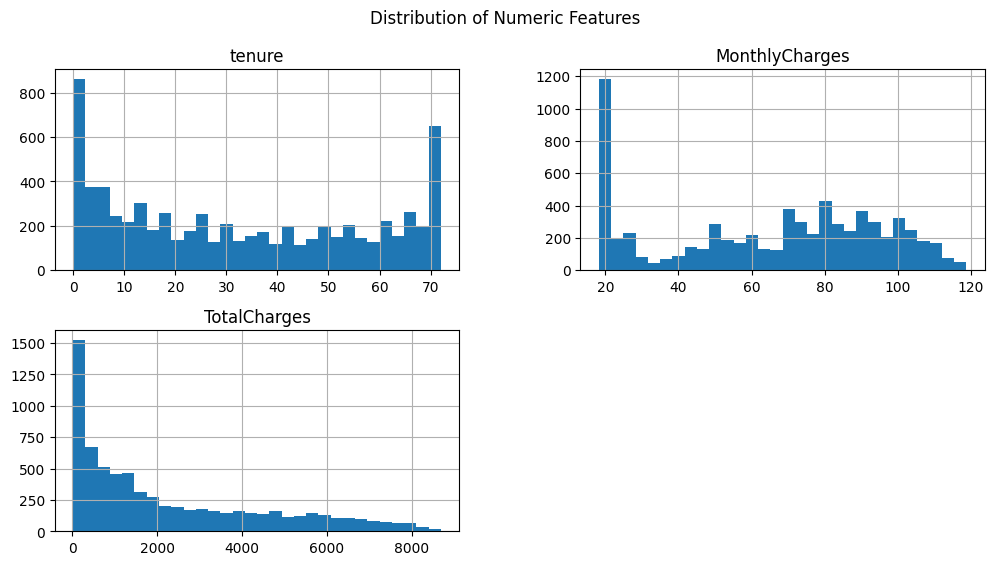

In [30]:
# univariate analysis
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

df[num_features].hist(bins=30, figsize=(12,6))
plt.suptitle("Distribution of Numeric Features")
plt.show()

### 5. Numeric Features vs. Churn (Linearity Preview)

Boxplots show whether churn differs across numeric features.  
This gives an early view of potential non-linearities.

⚠️ Example interpretation (check with your plots):  
- Churn is higher among customers with low `tenure`.  
- Higher `MonthlyCharges` are associated with slightly more churn.  
- `TotalCharges` is lower for churned customers (since they often left earlier).

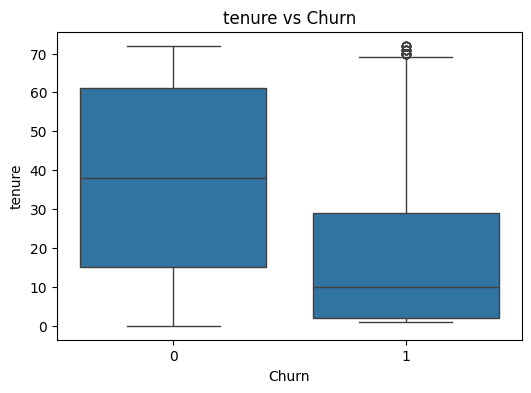

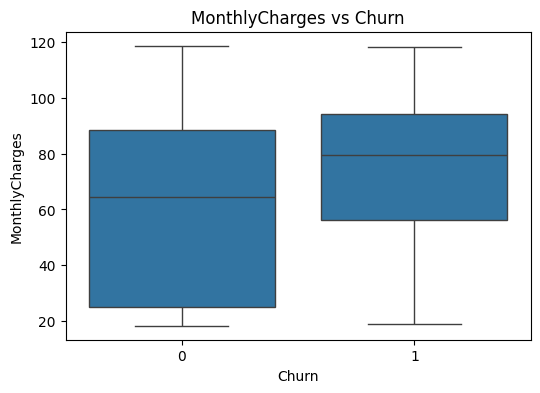

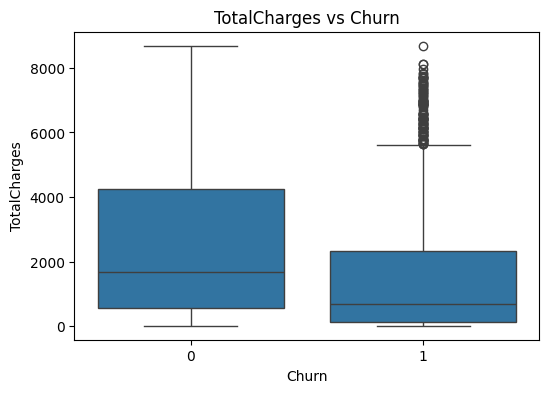

In [19]:
# churn vs numeric features
for col in num_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f"{col} vs Churn")
    plt.show()

### 6. Categorical Features vs. Churn

We check whether churn varies across demographic and account categories.

⚠️ Example interpretation (check with your plots):  
- Month-to-month contracts show much higher churn.  
- Electronic check users churn more often.  
- Gender does not appear to affect churn.

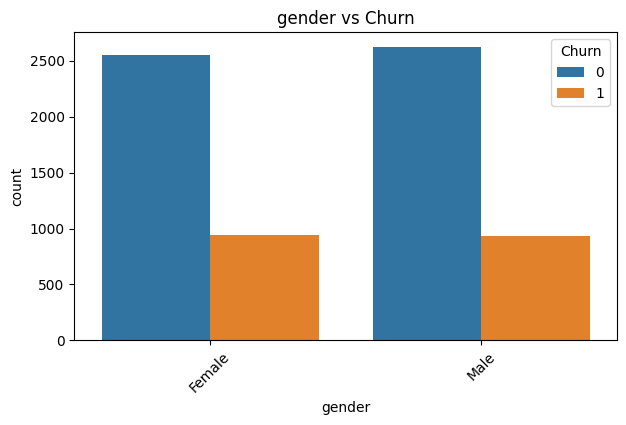

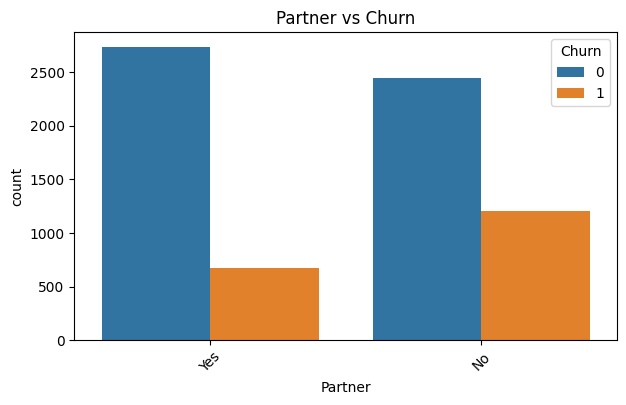

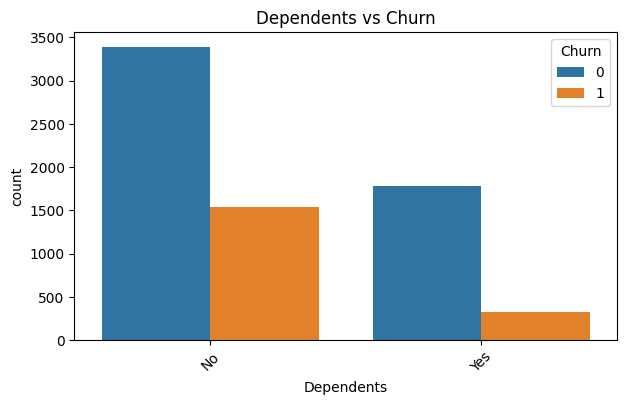

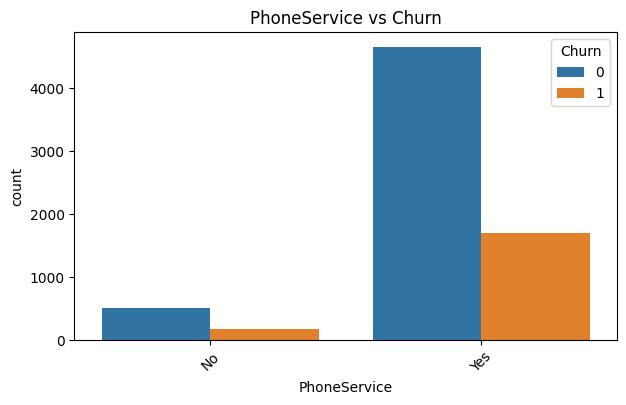

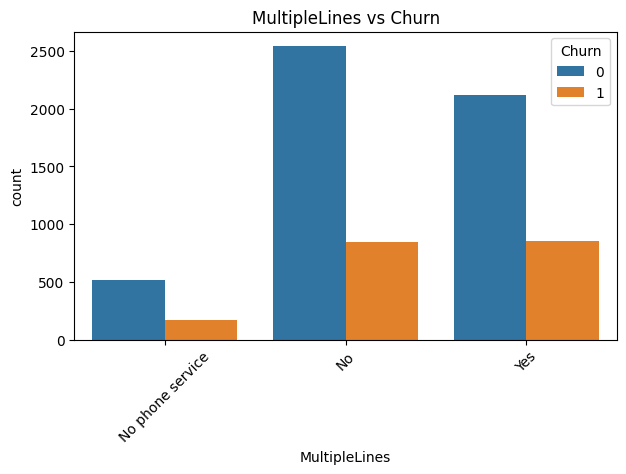

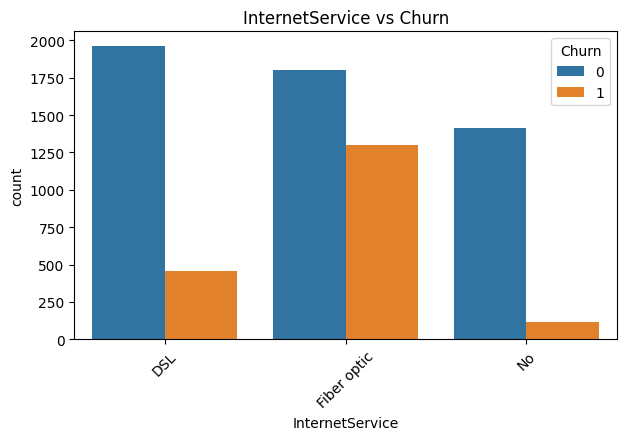

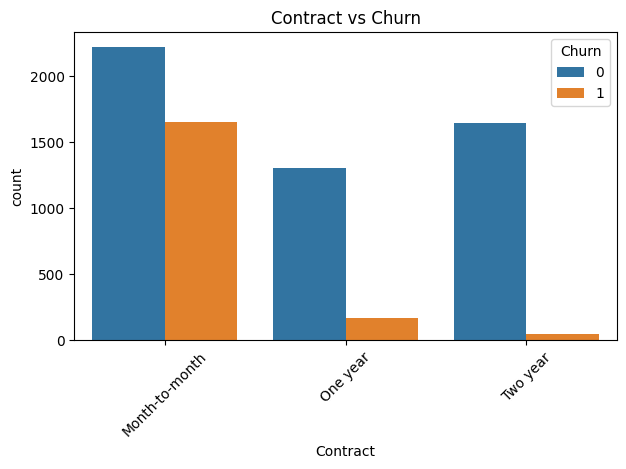

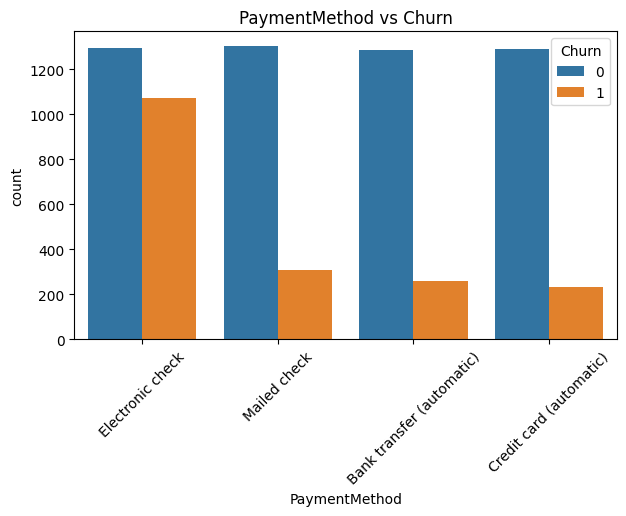

In [31]:
# churn vs categorical features
cat_features = ['gender','Partner','Dependents','PhoneService','MultipleLines',
                'InternetService','Contract','PaymentMethod']

for col in cat_features:
    plt.figure(figsize=(7,4))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=45)
    plt.show()

### 7. Correlation Between Numerical Features (Multicollinearity Preview)

We compute correlations among numeric features to check for multicollinearity, which can negatively affect linear regression models.  
Highly correlated predictors may provide redundant information.  

⚠️ Example interpretation:  
- `TotalCharges` and `tenure` are strongly correlated.  
- `MonthlyCharges` is moderately correlated with `TotalCharges`.  

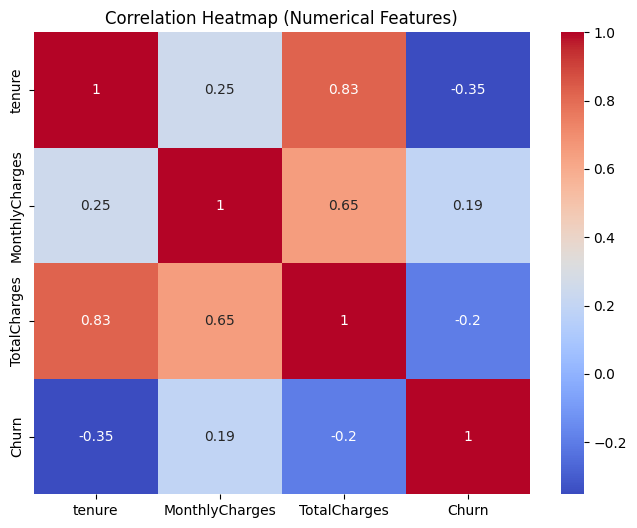

In [16]:
# correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(df[num_features + ['Churn']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

### 9. Assumption Checks Summary

- **Linearity**: Tenure shows a likely non-linear relationship with churn.  
- **Independence**: Customers are independent, so assumption holds.  
- **Homoscedasticity**: To be tested later using residuals.  
- **Normality**: Numeric features are skewed; residual normality to be tested later.  
- **Multicollinearity**: Some correlation between tenure, MonthlyCharges, and TotalCharges (check VIF later).  
- **Outliers**: Extreme values exist in `TotalCharges`.  

➡️ We will revisit assumptions requiring residuals during model fitting (linear, logistic, GAM).

# Linear Regression
 Treat the churn variable as a continuous variable (e.g., 0 for staying, 1 for churning) and build a linear regression model to predict churn. Interpret the coefficients and assess the model's performance.

#Logistic Regression
Treat churn as a binary variable and build a logistic regression model to predict the probability of churn. Interpret the coefficients.

# Generalized Additive Model (GAM)
Build a GAM to model the non-linear relationships between customer features and churn. Interpret the GAM model.

# Model Comparison
Compare the performance and interpretability of the different models you built. Discuss the strengths and weaknesses of each approach and provide recommendations for which model(s) the telecommunications company should use to address their customer churn problem.